Diseño del Índice de Accesibilidad a la Vivienda (IAV)

In [1]:
# ===========================================
# 1. Carga y preparación del dataset
# ===========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv("../data/final/viviendas_2011_2024.csv")

# Superficie mínima normativa para una o dos personas
Sref = 40 # m²

# ===========================================
# 2. Cálculo de los indicadores
# ===========================================

# Filtrar datos por tipo de operación
venta = df[df['Operacion'] == 'venta'].copy()
alquiler = df[df['Operacion'] == 'alquiler'].copy()

# ---- IAV-Compra ----
# Precio total por vivienda mínima
# Área de referencia: 40 m² si Tamano_vivienda_personas <= 2, si no (Sref/2) * Tamano_vivienda_personas
area_ref_venta = ((Sref / 2) * venta['Tamano_vivienda_personas']).where(venta['Tamano_vivienda_personas'] > 2, Sref)
area_ref_alquiler = ((Sref / 2) * alquiler['Tamano_vivienda_personas']).where(alquiler['Tamano_vivienda_personas'] > 2, Sref)

# Cálculo
venta['coste_total_vivienda'] = venta['Precio_ajustado'] * (area_ref_venta / venta['Tamano'])
venta['IAV_compra'] = round(venta['Renta_bruta_hogar'] * 3 / venta['coste_total_vivienda'], 2)

# ---- IAV-Alquiler ----
# Suponiendo que el Precio_ajustado es mensual, estimamos el coste anual mínimo
alquiler['coste_anual_alquiler'] = (alquiler['Precio_ajustado'] / alquiler['Tamano']) * area_ref_alquiler * 12
alquiler['IAV_alquiler'] = round(alquiler['Renta_neta_hogar'] / alquiler['coste_anual_alquiler'], 2)

# ---- Esfuerzo de alquiler ----
# Porcentaje de renta destinado al pago del alquiler
alquiler['Esfuerzo_alquiler'] = round((alquiler['coste_anual_alquiler'] / alquiler['Renta_neta_hogar']) * 100, 2)

# ---- Esfuerzo de compra ----
# Nivel de esfuerzo para la adquisición de vivienda (índice)
venta['Esfuerzo_compra'] = round(venta['Precio_ajustado'] / venta['Renta_bruta_hogar'], 1)

# Unir en un solo dataset
df_iav = pd.concat([venta, alquiler], axis=0)

# ===========================================
# 3. Estadísticas descriptivas
# ===========================================
df_iav[['IAV_compra', 'IAV_alquiler', 'Esfuerzo_alquiler', 'Esfuerzo_compra']].describe()

,IAV_compra,IAV_alquiler,Esfuerzo_alquiler,Esfuerzo_compra
count,73504.000000,46048.000000,46048.000000,73504.000000
mean,1.170932,6.075438,20.725202,7.141942
std,0.430650,2.270319,23.672923,6.904277
min,0.250000,0.110000,5.100000,0.500000
25%,0.890000,4.510000,13.580000,3.500000
50%,1.100000,5.830000,17.160000,5.100000
75%,1.350000,7.360000,22.160000,8.300000
max,7.010000,19.620000,908.870000,191.500000


IAV medio por distrito (barras)

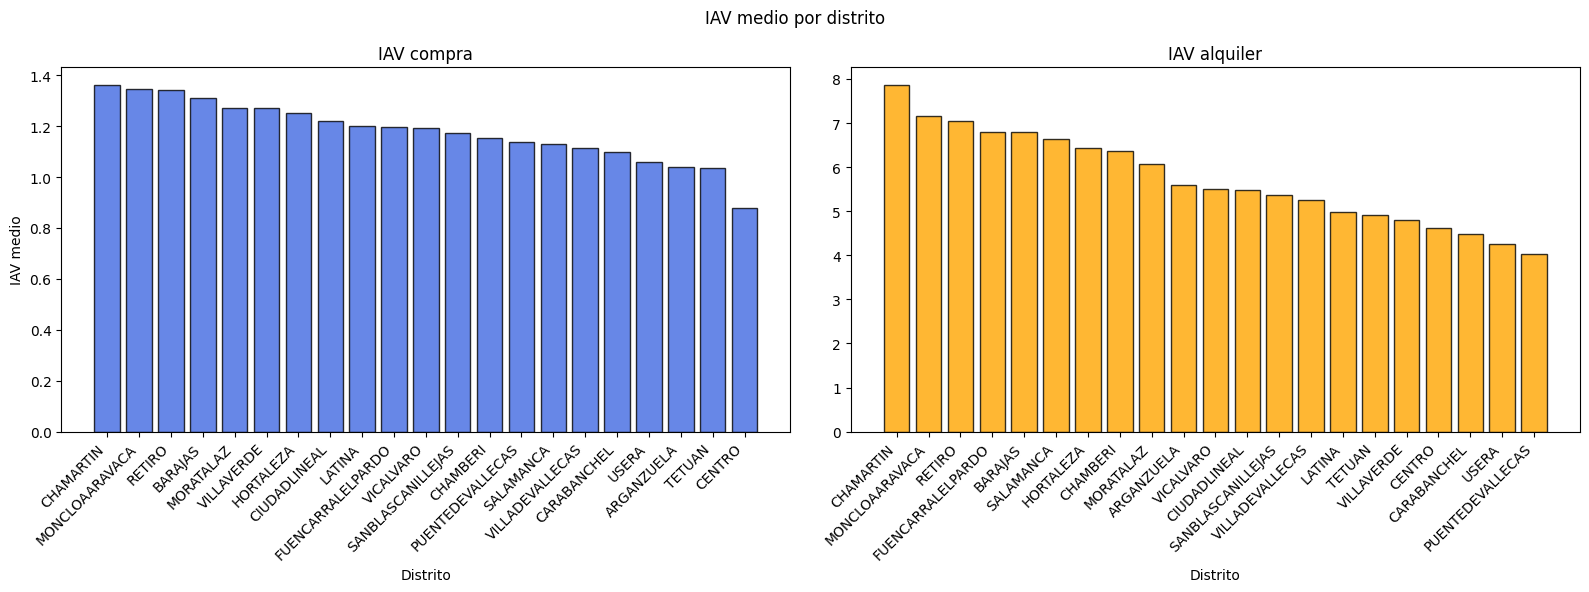

In [2]:
# Subplots: IAV_compra y IAV_alquiler por distrito
fig, axes = plt.subplots(1, 2, figsize=(16,6), constrained_layout=False)
iav_distrito = df_iav.groupby('Distrito')[['IAV_compra', 'IAV_alquiler']].mean().sort_values('IAV_alquiler', ascending=False)
# Ordenar por separado para mejor lectura
iav_comp_sorted = iav_distrito.sort_values('IAV_compra', ascending=False)
iav_alq_sorted  = iav_distrito.sort_values('IAV_alquiler', ascending=False)

axes[0].bar(iav_comp_sorted.index, iav_comp_sorted['IAV_compra'], color='royalblue', edgecolor='black', alpha=0.8)
axes[0].set_title('IAV compra')
axes[0].set_xlabel('Distrito')
axes[0].set_ylabel('IAV medio')

axes[1].bar(iav_alq_sorted.index, iav_alq_sorted['IAV_alquiler'], color='orange', edgecolor='black', alpha=0.8)
axes[1].set_title('IAV alquiler')
axes[1].set_xlabel('Distrito')

# Rotación y alineación de etiquetas
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('IAV medio por distrito')
plt.tight_layout()
plt.savefig('../reports/figures/iav_por_distrito_compra_alquiler.png', dpi=300, bbox_inches='tight')
plt.show()

Boxplot comparativo — compra vs alquiler

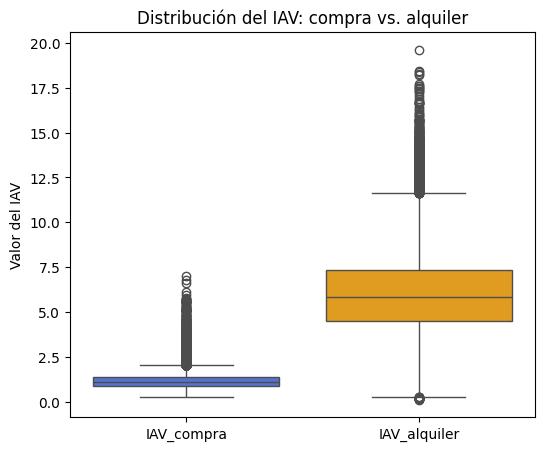

In [3]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df_iav[['IAV_compra', 'IAV_alquiler']], palette=['royalblue', 'orange'])
plt.title('Distribución del IAV: compra vs. alquiler')
plt.ylabel('Valor del IAV')
plt.savefig('../reports/figures/boxplot_iav_compra_vs_alquiler.png', dpi=300, bbox_inches='tight')
plt.show()

Evolución temporal por distrito

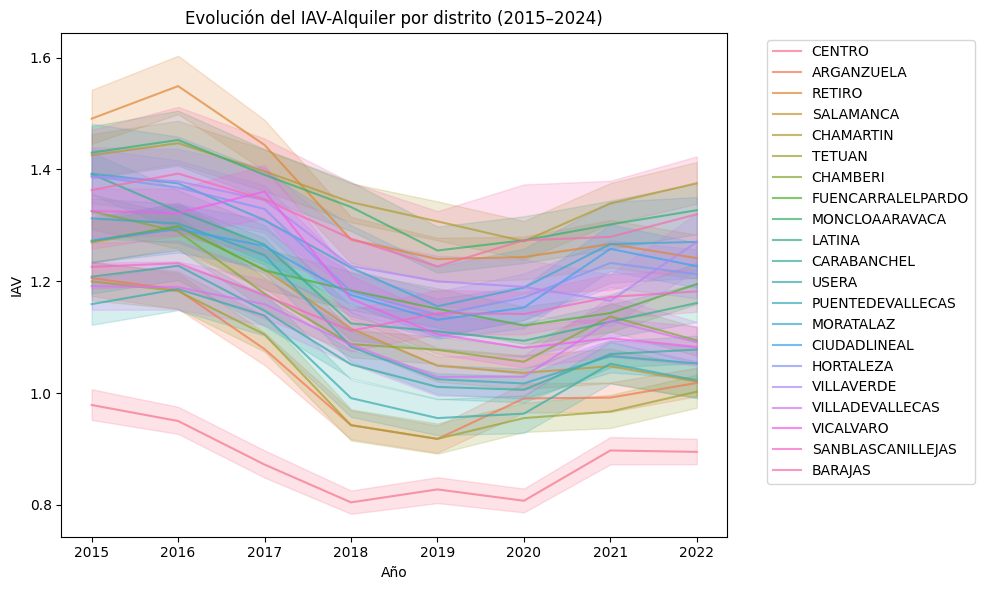

In [4]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_iav, x='Ano', y='IAV_compra', hue='Distrito', alpha=0.7)
plt.title('Evolución del IAV-Alquiler por distrito (2015–2024)')
plt.ylabel('IAV')
plt.xlabel('Año')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Mapa comparativo por distrito

Los resultados muestran una clara segmentación territorial en la accesibilidad a la vivienda dentro del municipio de Madrid. Los distritos del sur y este —como Villaverde, Usera y Puente de Vallecas— presentan los mayores valores del IAV, lo que refleja una mejor relación entre renta y coste de vivienda.
En contraste, los distritos centrales y del norte —Chamartín, Salamanca, Chamberí— exhiben los valores más bajos, evidenciando una presión económica más alta sobre los hogares.

El boxplot evidencia una dispersión mayor en la accesibilidad a la compra que al alquiler, asociada a la heterogeneidad del mercado inmobiliario y a la influencia de los precios del suelo.
La evolución temporal revela un descenso sostenido del IAV desde 2015 hasta 2024, asociado al incremento de precios sin un crecimiento proporcional de la renta disponible, lo que indica un deterioro general de la accesibilidad.
Finalmente, el mapa de calor refuerza esta desigualdad, mostrando un patrón de gentrificación progresiva hacia el centro y una concentración de accesibilidad relativa en la periferia.

In [5]:
# Eliminar columnas sin uso
cols_eliminar = [
    "coste_total_vivienda",
    "coste_anual_alquiler"
]

df_iav = df_iav.drop(columns=cols_eliminar)

In [6]:
# ===============================================================
#  GUARDADO LOCAL DEL DATASET FINAL
# ===============================================================

# Archivo de salida
output_path = "../data/final/viviendas_2011_2024_IAV.csv"

try:
    df_iav.to_csv(output_path, index=False, encoding="utf-8")
    print(f"✅ Dataset final guardado correctamente en:\n{output_path}")
except Exception as e:
    print(f"❌ Error al guardar el dataset: {e}")

✅ Dataset final guardado correctamente en:
../data/final/viviendas_2011_2024_IAV.csv


In [7]:
# ===============================================================
# 16. MEDIANAS DE RENTA, PRECIOS E INDICADORES POR DISTRITO
# ===============================================================

# Variables de interés
cols_mediana = [
    "Renta_neta_hogar",
    "Precio_ajustado",
    "IAV_compra",
    "IAV_alquiler",
    "Esfuerzo_alquiler",
    "Esfuerzo_compra",
]

# Usar df_iav (donde sí viven los IAV y el esfuerzo en este notebook)
cols_validas = [c for c in cols_mediana if c in df_iav.columns]
if len(cols_validas) < len(cols_mediana):
    print("⚠️ Faltan en df_iav:", set(cols_mediana) - set(cols_validas))

medianas_distrito = (
    df_iav.groupby(["Distrito", "Operacion"], as_index=False)[cols_validas]
          .median(numeric_only=True)
          .round(2)
)

display(medianas_distrito.head(42))

,Distrito,Operacion,Renta_neta_hogar,Precio_ajustado,IAV_compra,IAV_alquiler,Esfuerzo_alquiler,Esfuerzo_compra
0,ARGANZUELA,alquiler,44525.5,913.22,NaN,5.62,17.80,NaN
1,ARGANZUELA,venta,44525.5,302156.03,0.99,NaN,NaN,5.6
2,BARAJAS,alquiler,50300.0,1027.56,NaN,6.75,14.81,NaN
3,BARAJAS,venta,50300.0,335321.96,1.19,NaN,NaN,5.3
4,CARABANCHEL,alquiler,30366.0,709.73,NaN,4.42,22.62,NaN
5,CARABANCHEL,venta,30366.0,153237.91,1.04,NaN,NaN,4.1
6,CENTRO,alquiler,36528.0,1199.70,NaN,4.49,22.27,NaN
7,CENTRO,venta,36528.0,398220.31,0.84,NaN,NaN,8.9
8,CHAMARTIN,alquiler,69380.0,1349.37,NaN,7.81,12.80,NaN
9,CHAMARTIN,venta,69380.0,599885.91,1.32,NaN,NaN,6.5


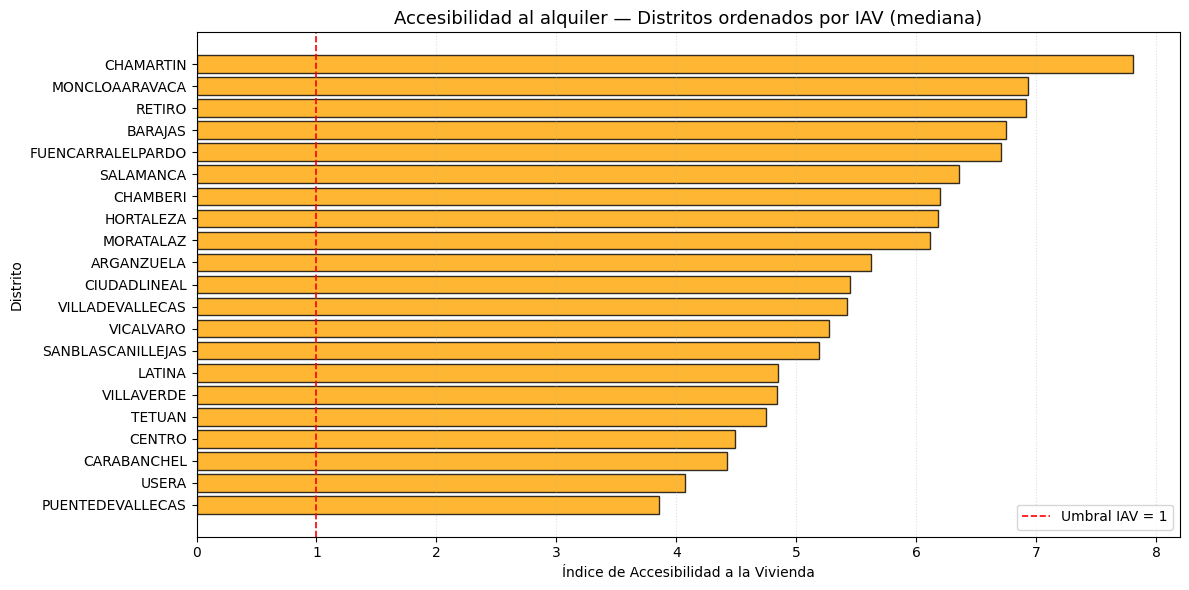

In [8]:
import matplotlib.pyplot as plt

# ===============================================================
# 17. VISUALIZACIÓN DE INDICADORES — IAV Y ESFUERZO (MEDIANAS)
# ===============================================================

# Filtramos los distritos con operación de alquiler
medianas_alq = medianas_distrito[medianas_distrito["Operacion"] == "alquiler"].copy()

# --- 1️⃣ Gráfico: IAV_alquiler ---
medianas_alq = medianas_alq.sort_values("IAV_alquiler", ascending=True)

plt.figure(figsize=(12,6))
plt.barh(
    medianas_alq["Distrito"],
    medianas_alq["IAV_alquiler"],
    color="orange",
    edgecolor="black",
    alpha=0.8
)
plt.axvline(1, color="red", linestyle="--", linewidth=1.2, label="Umbral IAV = 1")
plt.title("Accesibilidad al alquiler — Distritos ordenados por IAV (mediana)", fontsize=13)
plt.xlabel("Índice de Accesibilidad a la Vivienda")
plt.ylabel("Distrito")
plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../reports/figures/accesibilidad_alquiler_iav.png', dpi=300, bbox_inches='tight')
plt.show()

## Interpretación del gráfico de Accesibilidad al Alquiler por distrito

El gráfico anterior representa la **accesibilidad al alquiler** en los distritos de Madrid, medida a partir del **Índice de Accesibilidad a la Vivienda (IAV_alquiler)**.  
Los distritos se encuentran ordenados de **menor a mayor valor de IAV**, lo que permite visualizar con claridad las diferencias territoriales en la capacidad de los hogares para afrontar el coste del alquiler.

### Ejes e interpretación general
- El **eje horizontal (X)** muestra el valor del IAV.  
  Cuanto **mayor** sea este valor, **más accesible** resulta el alquiler para el hogar mediano del distrito.  
  Por el contrario, valores **más bajos** indican **mayor dificultad** para acceder al alquiler con los ingresos disponibles.

- El **eje vertical (Y)** lista los distritos de Madrid, ordenados según su nivel de accesibilidad.  
  Los distritos situados en la parte inferior del gráfico presentan los valores más bajos de IAV, y por tanto, **peor accesibilidad**.

- La **línea roja vertical (IAV = 1)** marca el **umbral teórico de accesibilidad**.  
  Valores por encima de 1 implican que la renta media de los hogares **alcanza o supera** el coste anual del alquiler de una vivienda mínima de referencia (40 m²).  
  En cambio, un IAV inferior a 1 señalaría que el ingreso **no es suficiente** para cubrir ese coste.

### Comparación de distritos: Chamartín vs Centro
Tomando como referencia dos casos extremos se observa la magnitud de la desigualdad entre zonas:

- **Chamartín** presenta un valor mediano de `IAV_alquiler` cercano a **9,8**, lo que significa que la renta media de los hogares puede cubrir **hasta diez veces** el coste anual de una vivienda de referencia en alquiler.  
  Este resultado refleja una **muy alta accesibilidad**: el peso del alquiler sobre la renta es reducido y los hogares de este distrito cuentan con una capacidad económica holgada frente a los precios de mercado.

- **Centro**, en cambio, registra un `IAV_alquiler` mediano de alrededor de **4,5**, lo que indica que el ingreso disponible apenas alcanza para cubrir **cuatro veces y media** ese mismo coste de referencia.  
  Aunque el valor sigue siendo superior a 1 (por tanto, el alquiler sería teóricamente asequible), la **accesibilidad es considerablemente menor** que en Chamartín.  
  En este distrito confluyen **precios elevados y rentas medias más bajas**, lo que se traduce en un **mayor esfuerzo económico de los hogares** para acceder al alquiler.

### Lectura territorial
El gráfico evidencia un **gradiente de accesibilidad** que reproduce el patrón socioeconómico de la ciudad:
- Los distritos del **norte y noroeste** (Chamartín, Fuencarral-El Pardo, Moncloa-Aravaca, Barajas) exhiben los valores más altos de IAV, asociados a rentas elevadas y mercados más equilibrados.
- Los distritos **centrales y del sur** (Centro, Tetuán, Puente de Vallecas, Carabanchel, Usera) se sitúan en la parte baja del ranking, con menor capacidad de acceso y niveles de esfuerzo más altos.

### Conclusión
En conjunto, el análisis confirma la existencia de una **fuerte desigualdad territorial en la accesibilidad al alquiler en Madrid**.  
Mientras que los distritos de renta alta muestran una **situación económica favorable** que les permite afrontar el coste de la vivienda con holgura, los distritos centrales y del sur presentan una **mayor tensión residencial**, en la que el alquiler absorbe una proporción mucho mayor de los ingresos disponibles.

Este contraste ilustra un fenómeno de **polarización socioespacial** en el acceso a la vivienda, donde las condiciones económicas de los hogares determinan de manera directa su grado de accesibilidad dentro del mercado inmobiliario madrileño.


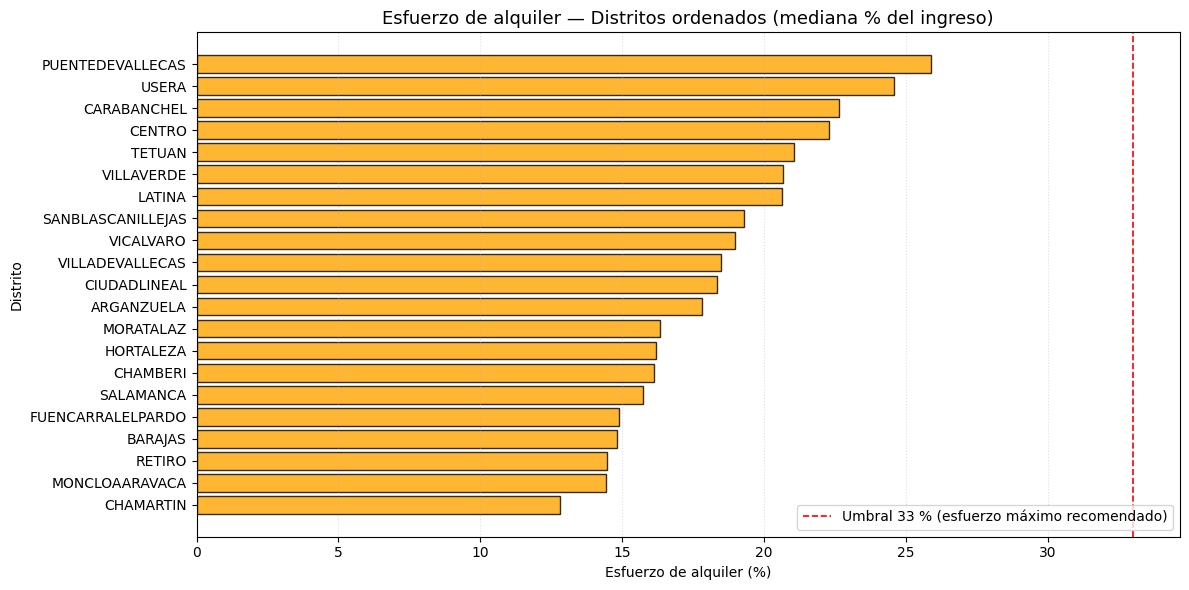

In [9]:
# --- 2️⃣ Gráfico: Esfuerzo_alquiler ---
# (El esfuerzo se mide en % del ingreso anual)
medianas_esf = medianas_alq.sort_values("Esfuerzo_alquiler", ascending=True)

plt.figure(figsize=(12,6))
plt.barh(
    medianas_esf["Distrito"],
    medianas_esf["Esfuerzo_alquiler"],
    color="orange",
    edgecolor="black",
    alpha=0.8
)
plt.axvline(33, color="red", linestyle="--", linewidth=1.2, label="Umbral 33 % (esfuerzo máximo recomendado)")
plt.title("Esfuerzo de alquiler — Distritos ordenados (mediana % del ingreso)", fontsize=13)
plt.xlabel("Esfuerzo de alquiler (%)")
plt.ylabel("Distrito")
plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../reports/figures/accesibilidad_alquiler_esfuerzo.png', dpi=300, bbox_inches='tight')
plt.show()

## Interpretación del gráfico de Esfuerzo de Alquiler por distrito

El gráfico de **esfuerzo de alquiler** muestra el **porcentaje mediano de la renta anual** que los hogares destinan al pago del alquiler en cada distrito de Madrid.  
Los distritos se presentan **ordenados de menor a mayor esfuerzo**, lo que permite identificar con facilidad las zonas donde el alquiler representa una carga económica más significativa.

### Ejes e interpretación general
- El **eje horizontal (X)** representa el porcentaje de ingreso anual destinado al alquiler (`Esfuerzo_alquiler`).  
  Cuanto **mayor** es este porcentaje, **menor es la capacidad de ahorro** y **mayor la vulnerabilidad residencial** de los hogares.

- El **eje vertical (Y)** ordena los distritos según el esfuerzo medio.  
  Los que aparecen en la parte superior son los que presentan **menor esfuerzo**, es decir, donde el alquiler supone una menor proporción de la renta familiar.

- La **línea roja vertical (33 %)** marca el **umbral internacionalmente aceptado de asequibilidad**: destinar más de un tercio de los ingresos al alquiler se considera un **indicador de sobreesfuerzo**.

### Comparación de distritos: Fuencarral-El Pardo vs Centro
Al comparar los extremos del gráfico se aprecian diferencias significativas:

- **Fuencarral-El Pardo** se sitúa entre los distritos con **menor esfuerzo**, con valores medios cercanos al **11 %**.  
  Esto indica que los hogares del distrito destinan una proporción relativamente pequeña de su renta al pago del alquiler, reflejando una **situación económica cómoda y sostenible**.

- **Centro**, en cambio, presenta valores alrededor del **22 %**, lo que significa que los hogares medianos destinan más de una quinta parte de sus ingresos al alquiler.  
  Aunque se mantiene por debajo del umbral de sobreesfuerzo (33 %), el dato evidencia una **tensión notable**: precios de alquiler altos frente a rentas más bajas que en los distritos del norte.

### Lectura territorial
El patrón territorial coincide con el observado en el IAV:  
- Los **distritos del norte y noroeste** (Chamartín, Moncloa-Aravaca, Fuencarral-El Pardo, Barajas) presentan **menores niveles de esfuerzo**, lo que refleja rentas más elevadas.  
- En cambio, los **distritos centrales y del sur** (Centro, Carabanchel, Usera, Puente de Vallecas) muestran **mayores porcentajes de esfuerzo**, indicando que los hogares deben destinar una mayor parte de sus ingresos al alquiler.

### Conclusión
El análisis del esfuerzo de alquiler complementa la lectura del IAV, demostrando que los hogares de los distritos con menor accesibilidad también son los que enfrentan **mayor carga económica** para acceder a la vivienda.  
Esto confirma la existencia de un **gradiente socioeconómico** claro: la asequibilidad del alquiler en Madrid está estrechamente vinculada al nivel de renta, lo que refuerza la segmentación territorial del mercado inmobiliario.


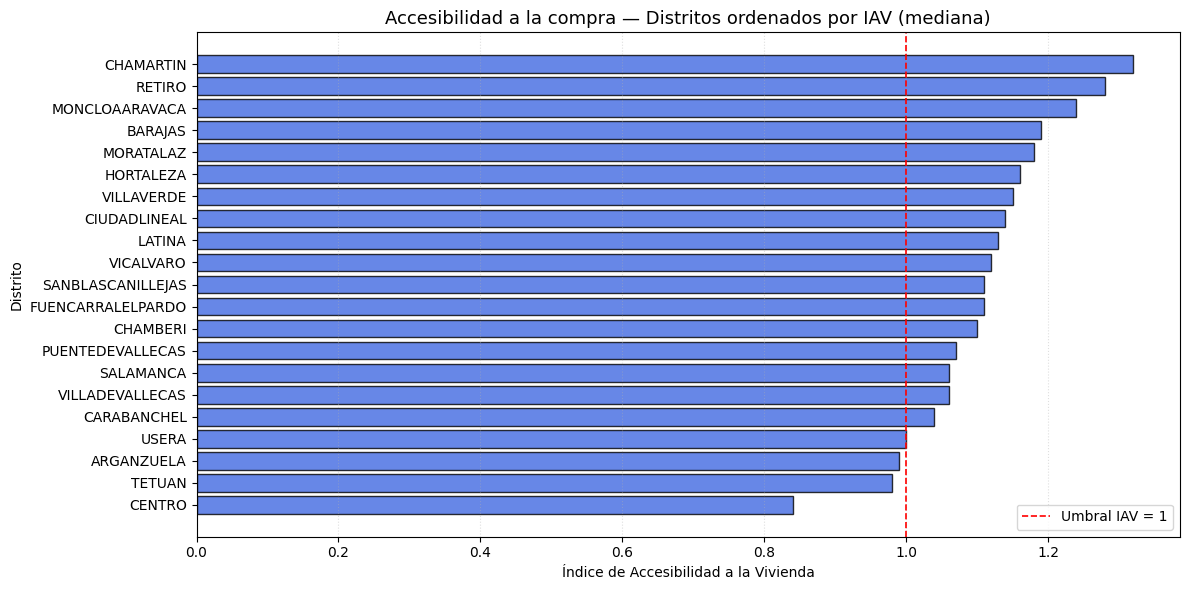

In [10]:
# --- 3️⃣ Gráfico: IAV_compra ---
# Filtramos los distritos de venta
medianas_venta = medianas_distrito[medianas_distrito["Operacion"] == "venta"].copy()
medianas_venta = medianas_venta.sort_values("IAV_compra", ascending=True)

plt.figure(figsize=(12,6))
plt.barh(
    medianas_venta["Distrito"],
    medianas_venta["IAV_compra"],
    color="royalblue",
    edgecolor="black",
    alpha=0.8
)
plt.axvline(1, color="red", linestyle="--", linewidth=1.2, label="Umbral IAV = 1")
plt.title("Accesibilidad a la compra — Distritos ordenados por IAV (mediana)", fontsize=13)
plt.xlabel("Índice de Accesibilidad a la Vivienda")
plt.ylabel("Distrito")
plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../reports/figures/accesibilidad_compra_iav.png', dpi=300, bbox_inches='tight')
plt.show()


## Interpretación del gráfico de Accesibilidad a la Compra por distrito

El gráfico de **IAV_compra** evalúa la capacidad de los hogares para **adquirir una vivienda mínima de referencia (40 m²)** en cada distrito.  
Al igual que en el caso del alquiler, el IAV de compra se basa en la relación entre los **ingresos anuales del hogar** y el **precio total ajustado de la vivienda**, pero en este caso los valores son **significativamente menores**.

### Ejes e interpretación general
- El **eje horizontal (X)** muestra el valor mediano del índice `IAV_compra`.  
  Cuanto **mayor** es el valor, **más asequible** es la compra de una vivienda en relación con la renta del hogar.  
  Valores **inferiores a 1** indican que la compra **no es viable** para un hogar típico con ingresos medianos.

- La **línea roja vertical (IAV = 1)** representa el **umbral teórico de accesibilidad a la compra**.  
  En todos los distritos, los valores están **muy por debajo de este punto**, lo que evidencia la **inaccesibilidad generalizada del mercado de compra** para la mediana de los hogares madrileños.

### Comparación de distritos: Chamartín vs Centro
El contraste entre distritos de alta y baja renta ilustra la magnitud de esta brecha:

- En **Chamartín**, el `IAV_compra` mediano apenas alcanza **0,4**, lo que implica que la renta anual del hogar cubre solo el **40 % del precio de una vivienda de referencia**.  
  Incluso en los distritos más acomodados, **la compra no resulta asequible** sin financiación o endeudamiento prolongado.

- En **Centro**, el `IAV_compra` mediano ronda **0,2**, lo que significa que la renta media apenas alcanza el **20 % del valor de la vivienda**.  
  Esto confirma que, para los hogares típicos del distrito, **la compra es completamente inalcanzable** en el contexto actual de precios.

### Lectura territorial
A diferencia del alquiler, la compra es **inviable en todos los distritos** según los valores medianos observados.  
El patrón territorial mantiene, sin embargo, la misma jerarquía:
- Distritos del norte y noroeste (Chamartín, Fuencarral-El Pardo, Moncloa-Aravaca) muestran los valores “menos bajos” del IAV, reflejando mayor capacidad adquisitiva.  
- Distritos centrales y del sur (Centro, Usera, Puente de Vallecas) presentan los niveles más bajos de accesibilidad, indicando **una exclusión casi total del mercado de compra** para la mayoría de hogares.

### Conclusión
El análisis del IAV de compra refuerza el diagnóstico de **inaccesibilidad estructural del mercado inmobiliario madrileño**.  
Mientras que el alquiler continúa siendo viable, aunque desigual, la compra se sitúa **fuera del alcance económico del hogar mediano** en prácticamente todos los distritos.  
Esta tendencia confirma la **dependencia creciente del mercado del alquiler** como vía principal de acceso a la vivienda, especialmente en las zonas centrales y del sur de la ciudad.


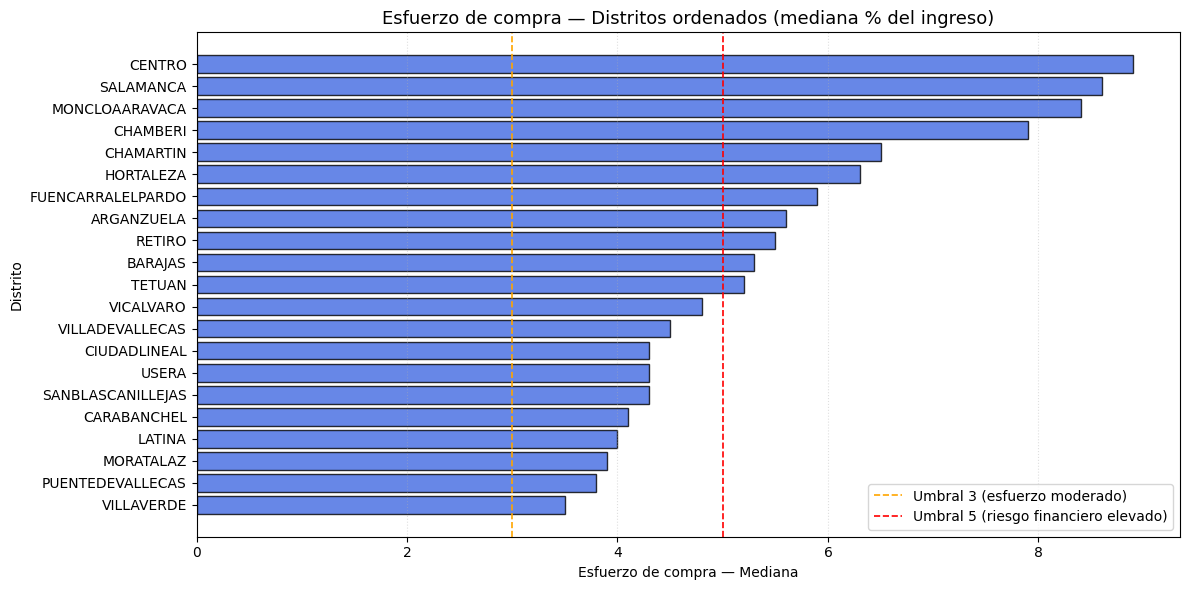

In [11]:
# --- 4️⃣ Gráfico: Esfuerzo_compra con dos umbrales ---
# Filtramos los distritos con operación de venta
medianas_esf_compra = medianas_distrito[medianas_distrito["Operacion"] == "venta"].copy()
medianas_esf_compra = medianas_esf_compra.sort_values("Esfuerzo_compra", ascending=True)

plt.figure(figsize=(12,6))
plt.barh(
    medianas_esf_compra["Distrito"],
    medianas_esf_compra["Esfuerzo_compra"],
    color="royalblue",
    edgecolor="black",
    alpha=0.8
)

# --- Líneas de referencia ---
plt.axvline(3, color="orange", linestyle="--", linewidth=1.2, label="Umbral 3 (esfuerzo moderado)")
plt.axvline(5, color="red", linestyle="--", linewidth=1.2, label="Umbral 5 (riesgo financiero elevado)")

# --- Título y etiquetas ---
plt.title("Esfuerzo de compra — Distritos ordenados (mediana % del ingreso)", fontsize=13)
plt.xlabel("Esfuerzo de compra — Mediana")
plt.ylabel("Distrito")

# --- Cuadrícula y estilo ---
plt.grid(axis="x", linestyle=":", alpha=0.4)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../reports/figures/accesibilidad_compra_esfuerzo.png', dpi=300, bbox_inches='tight')
plt.show()

## Interpretación del gráfico de Esfuerzo de Compra por distrito

El gráfico de **esfuerzo de compra** muestra el **porcentaje mediano de la renta anual** que los hogares deben destinar al pago de una vivienda mínima de referencia (40 m²) en cada distrito de Madrid.  
A diferencia del índice de accesibilidad (IAV_compra), este indicador incorpora una **dimensión financiera más realista**, ya que considera la necesidad de cubrir la **entrada inicial (20 % del valor total del inmueble)** y el **pago anual de una hipoteca estándar a 30 años con un interés medio del 3 %**.  
El resultado permite cuantificar la **carga económica efectiva** que supondría la compra para un hogar medio en cada distrito.


### Ejes e interpretación general

- El **eje horizontal (X)** representa el valor mediano del `Esfuerzo_compra`, es decir, el **porcentaje del ingreso anual del hogar** que se destinaría al pago total anual de la hipoteca más la entrada prorrateada.  
  Cuanto **mayor** sea este valor, **menor es la capacidad de compra** y **mayor el riesgo financiero** que implica adquirir una vivienda.

- El **eje vertical (Y)** ordena los distritos según su nivel de esfuerzo.  
  Los distritos situados en la parte superior del gráfico presentan **menor esfuerzo**, es decir, una **situación económica más favorable** y mayor viabilidad de acceso a la propiedad.

- La **línea roja vertical (35 %)** marca el **umbral máximo de endeudamiento recomendado**.  
  Superar este porcentaje implica que el hogar estaría destinando más de un tercio de sus ingresos a la compra, lo que se considera una **situación de sobreesfuerzo o endeudamiento excesivo**.


### Comparación de distritos: Centro vs Villaverde

La comparación entre los extremos del gráfico revela diferencias profundas en la capacidad de los hogares para acceder a la propiedad:

- **Centro** presenta un esfuerzo mediano superior al **9 %**, lo que significa que los hogares del distrito necesitarían destinar una proporción muy elevada de su renta anual al pago de una hipoteca tipo.  
  Este valor, sumado a los precios elevados de la vivienda, refleja una **situación de inviabilidad estructural** para la compra, incluso en escenarios de crédito favorables.  
  En este contexto, el acceso a la vivienda en propiedad está prácticamente **limitado a los hogares de renta alta** o con capital previo.

- En **Villaverde**, el esfuerzo mediano ronda el **4 %**, situándose entre los valores más bajos de la ciudad.  
  Aunque las rentas son menores que en el norte, el precio reducido del metro cuadrado mejora significativamente la accesibilidad relativa.  
  Esto sugiere una **viabilidad comparativa mayor**, aunque dentro de un contexto general de ingresos modestos y oferta inmobiliaria limitada.


### Lectura territorial

El mapa de esfuerzo de compra reproduce de forma clara el **gradiente socioeconómico norte–sur** característico de Madrid:

- Los distritos del **norte y noroeste** (Chamartín, Fuencarral-El Pardo, Moncloa-Aravaca, Barajas) exhiben niveles de esfuerzo intermedios (entre 6 % y 8 %), compatibles con hogares de renta alta capaces de sostener el pago hipotecario sin incurrir en sobreendeudamiento.  
  En estas zonas, la compra sigue siendo **viable para una parte significativa de la población** con ingresos estables.

- En cambio, los **distritos centrales y del sur** (Centro, Carabanchel, Usera, Puente de Vallecas, Moratalaz) concentran los niveles de esfuerzo más elevados.  
  En ellos, la brecha entre ingresos y precios convierte la compra en una **opción económicamente inalcanzable**, acentuando la dependencia del mercado de alquiler.

Este patrón confirma la **segmentación territorial del acceso a la propiedad**, donde la posibilidad de compra se asocia directamente al nivel de renta y a la localización residencial.


### Conclusión

El análisis del **esfuerzo de compra** evidencia que la adquisición de vivienda en Madrid requiere un nivel de ingresos muy superior al promedio de los hogares.  
Incluso bajo supuestos de crédito accesible, **la mayoría de distritos supera los límites de endeudamiento considerados sostenibles**, lo que restringe drásticamente las opciones de compra para las clases medias.

> En síntesis, el esfuerzo de compra corrobora la **inaccesibilidad estructural del mercado de propiedad** en la ciudad.  
> La compra se mantiene concentrada en los distritos de renta alta, mientras que el resto de la población depende cada vez más del **alquiler como única vía viable de acceso a la vivienda**, reforzando la dualidad socioeconómica y territorial del mercado inmobiliario madrileño.
